In [4]:
from massa_mola_1_corpo.dataset import get_position_and_force, build_dataset
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
dt = 0.001
k = 2
m = 1
c = 1
pos, force = get_position_and_force(dt=dt, k=k, m=m, c=c)

In [83]:
data = build_dataset(pos, force,dt=dt)

In [84]:
q, q_dot, q_dot2, f = np.expand_dims(data.transpose(), -1)

In [85]:
f

array([[ 0.001     ],
       [ 0.002     ],
       [ 0.003     ],
       ...,
       [-0.54150145],
       [-0.54234188],
       [-0.54318177]])

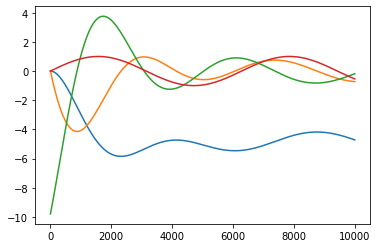

In [86]:
plt.plot(q)
plt.plot(q_dot)
plt.plot(q_dot2)
plt.plot(f)
plt.show()

In [87]:
from jax.experimental.stax import Dense, serial
import jax
import jax.numpy as jnp
import numpy as onp
from jax import grad, jit, vmap, value_and_grad, jacfwd, jacrev, jacobian, hessian
from jax import random
from jax.experimental import stax
from jax.experimental.optimizers import adam, sgd
from functools import partial
# Generate key which is used to generate random numbers
rng = random.PRNGKey(20)

In [88]:
"""

Utils

"""


def mse(y_true, y_pred):
    
    assert(jnp.squeeze(y_true).shape == jnp.squeeze(y_pred).shape)
    diff = jnp.squeeze(y_true) - np.squeeze(y_pred)
    return jnp.mean(jnp.square(diff))

"""

Modelo Físico

"""

def initialize_params(rng, dims):
    """ Inicializa massa k e c """
    keys = random.split(rng, 3)
    params = [random.normal(keys[i], [dims, dims]) for i in range(2)]
    return params
    
def forward_pass(params, q, q_dot, f, mass= jnp.array([[1, 0], [0, 1]])):
    """ 
    Uma instancia de x é do formato [x, x_dot] 
    Um forward pass estima a aceleração do sistema

    """
    q = q.reshape((-1, 1))
    q_dot = q_dot.reshape((-1, 1))
    f = f.reshape((-1, 1))
    M_inv = np.linalg.pinv(mass)
    C = params[1] @ q_dot 
    K = params[0] @ q
    return jnp.squeeze(M_inv @ (f - C - K) - 9.81, -1)

forward_pass = partial(forward_pass, mass=jnp.array([[m]]))
batch_forward_pass = vmap(forward_pass, in_axes=(None, 0, 0, 0), out_axes=0)

@jit
def loss(params, q, q_dot, q_dot2, f):
    pred = batch_forward_pass(params, q, q_dot, f)
    return mse(q_dot2, pred)


params = initialize_params(rng, dims=1)
params

[DeviceArray([[1.2093637]], dtype=float32),
 DeviceArray([[-0.6184139]], dtype=float32)]

In [89]:
forward_pass(params, q[0], q_dot[0], f[0])

batch_forward_pass(params, q, q_dot, f)

loss(params, q, q_dot, q_dot2, f)



DeviceArray(22.266699, dtype=float32)

In [90]:
loss([jnp.array([k]), jnp.array([c])], q, q_dot, q_dot2, f)

DeviceArray(1.1362274e-06, dtype=float32)

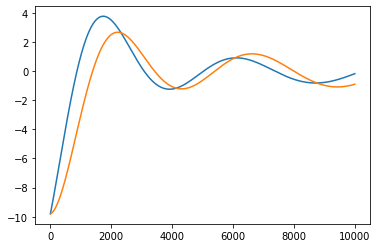

In [91]:
true_params = [jnp.array([[2.]]), jnp.array([[0]])]
pred = batch_forward_pass(true_params, q, q_dot, f)
plt.plot(q_dot2)
plt.plot(pred)


In [92]:
q[0]

array([-4.90319797e-06])

In [93]:
true_params[0] @ q[100].reshape((-1, 1))

DeviceArray([[-0.09628836]], dtype=float32)

In [94]:
q_dot

array([[-0.0049032 ],
       [-0.01470238],
       [-0.02449074],
       ...,
       [-0.72663598],
       [-0.7268214 ],
       [-0.72700602]])

# Treinamento

In [95]:
indexes = [i for i in range(len(q))]
np.random.shuffle(indexes)

q = q[indexes]
q_dot = q_dot[indexes]
q_dot2 = q_dot2[indexes]
f = f[indexes]

undo_shuffle = onp.argsort(indexes)

Epoch 0



Epoch 0 , mean error: 15.047361 params: [DeviceArray([[1.4938385]], dtype=float32), DeviceArray([[-0.35137433]], dtype=float32)]


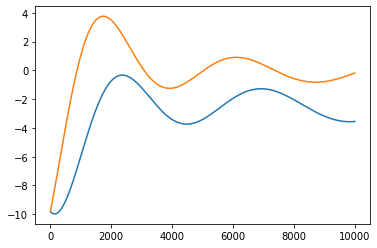

Epoch 1



Epoch 1 , mean error: 8.990158 params: [DeviceArray([[1.6238768]], dtype=float32), DeviceArray([[-0.21659341]], dtype=float32)]


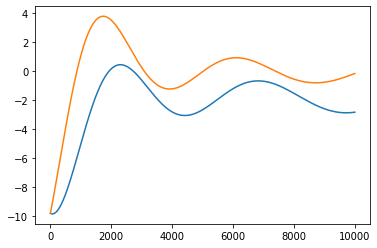

Epoch 2



Epoch 2 , mean error: 6.0812583 params: [DeviceArray([[1.7192473]], dtype=float32), DeviceArray([[-0.10991489]], dtype=float32)]


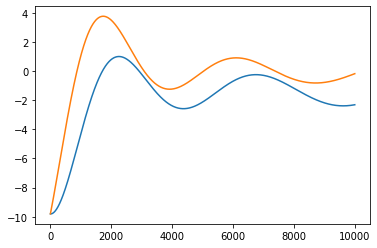

Epoch 3



Epoch 3 , mean error: 4.26146 params: [DeviceArray([[1.7951933]], dtype=float32), DeviceArray([[-0.01714566]], dtype=float32)]


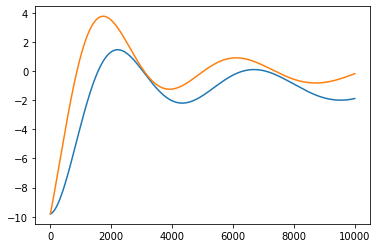

Epoch 4



Epoch 4 , mean error: 3.0492353 params: [DeviceArray([[1.8570532]], dtype=float32), DeviceArray([[0.06703695]], dtype=float32)]


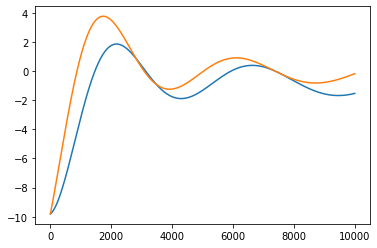

Epoch 5



Epoch 5 , mean error: 2.2245398 params: [DeviceArray([[1.9071945]], dtype=float32), DeviceArray([[0.14525814]], dtype=float32)]


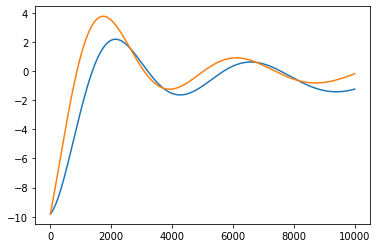

Epoch 6



Epoch 6 , mean error: 1.6588129 params: [DeviceArray([[1.9468431]], dtype=float32), DeviceArray([[0.21900961]], dtype=float32)]


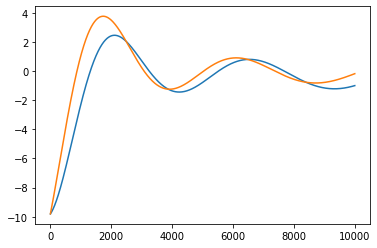

Epoch 7



Epoch 7 , mean error: 1.2664584 params: [DeviceArray([[1.9768392]], dtype=float32), DeviceArray([[0.28921422]], dtype=float32)]


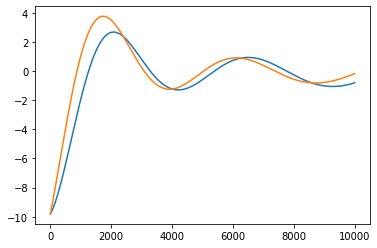

Epoch 8



Epoch 8 , mean error: 0.98743564 params: [DeviceArray([[1.9980453]], dtype=float32), DeviceArray([[0.35647044]], dtype=float32)]


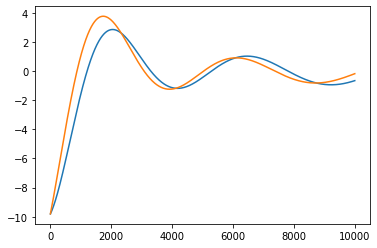

Epoch 9



Epoch 9 , mean error: 0.78021467 params: [DeviceArray([[2.011581]], dtype=float32), DeviceArray([[0.4211624]], dtype=float32)]


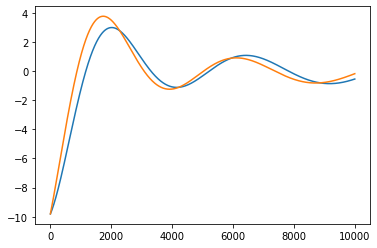

Epoch 10



Epoch 10 , mean error: 0.6180241 params: [DeviceArray([[2.0188797]], dtype=float32), DeviceArray([[0.48350856]], dtype=float32)]


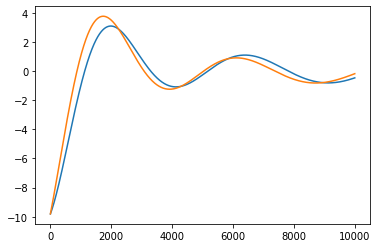

Epoch 11



Epoch 11 , mean error: 0.4854639 params: [DeviceArray([[2.0215714]], dtype=float32), DeviceArray([[0.54357904]], dtype=float32)]


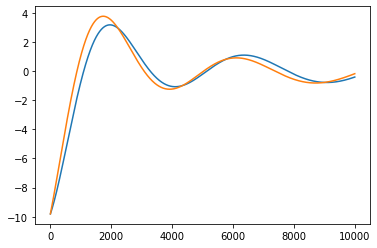

Epoch 12



Epoch 12 , mean error: 0.37479338 params: [DeviceArray([[2.0212646]], dtype=float32), DeviceArray([[0.601303]], dtype=float32)]


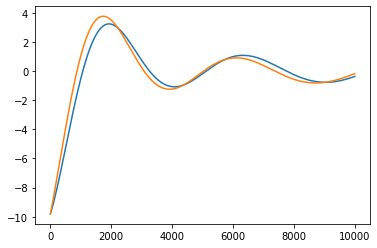

Epoch 13



Epoch 13 , mean error: 0.28246197 params: [DeviceArray([[2.0192995]], dtype=float32), DeviceArray([[0.6564792]], dtype=float32)]


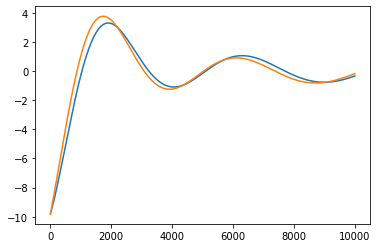

Epoch 14



Epoch 14 , mean error: 0.20664322 params: [DeviceArray([[2.016633]], dtype=float32), DeviceArray([[0.70879674]], dtype=float32)]


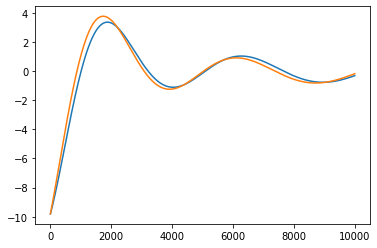

Epoch 15



Epoch 15 , mean error: 0.14593045 params: [DeviceArray([[2.0138285]], dtype=float32), DeviceArray([[0.7578573]], dtype=float32)]


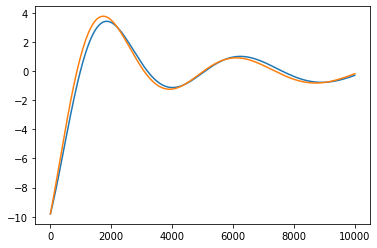

Epoch 16



Epoch 16 , mean error: 0.09884367 params: [DeviceArray([[2.0111666]], dtype=float32), DeviceArray([[0.8032077]], dtype=float32)]


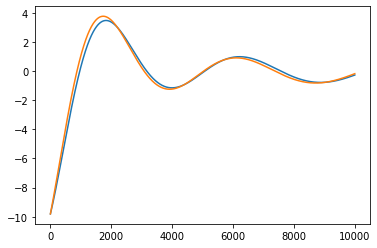

Epoch 17



Epoch 17 , mean error: 0.06371687 params: [DeviceArray([[2.0087614]], dtype=float32), DeviceArray([[0.84436923]], dtype=float32)]


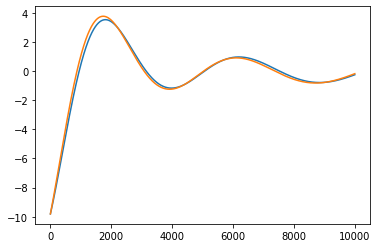

Epoch 18



Epoch 18 , mean error: 0.038720254 params: [DeviceArray([[2.006655]], dtype=float32), DeviceArray([[0.88087684]], dtype=float32)]


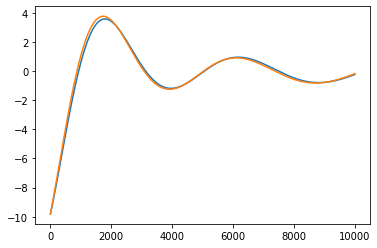

Epoch 19



Epoch 19 , mean error: 0.021926655 params: [DeviceArray([[2.00486]], dtype=float32), DeviceArray([[0.9123271]], dtype=float32)]


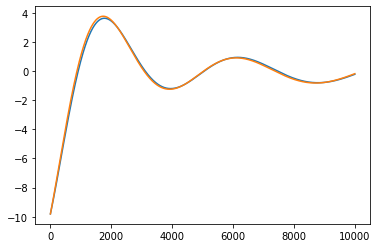

Epoch 20



Epoch 20 , mean error: 0.011410179 params: [DeviceArray([[2.003385]], dtype=float32), DeviceArray([[0.9384431]], dtype=float32)]


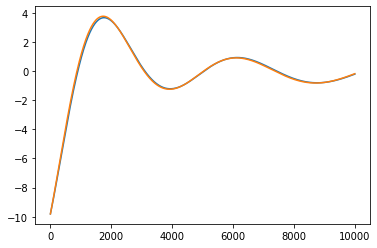

Epoch 21



Epoch 21 , mean error: 0.0053662607 params: [DeviceArray([[2.0022247]], dtype=float32), DeviceArray([[0.9591561]], dtype=float32)]


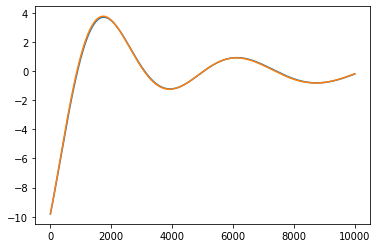

Epoch 22



Epoch 22 , mean error: 0.0022368317 params: [DeviceArray([[2.0013611]], dtype=float32), DeviceArray([[0.9746729]], dtype=float32)]


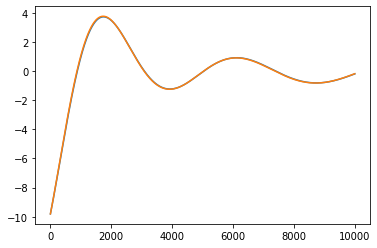

Epoch 23



Epoch 23 , mean error: 0.0008079956 params: [DeviceArray([[2.0007598]], dtype=float32), DeviceArray([[0.98551345]], dtype=float32)]


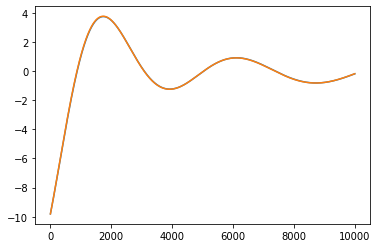

Epoch 24



Epoch 24 , mean error: 0.00024676623 params: [DeviceArray([[2.000375]], dtype=float32), DeviceArray([[0.99247366]], dtype=float32)]


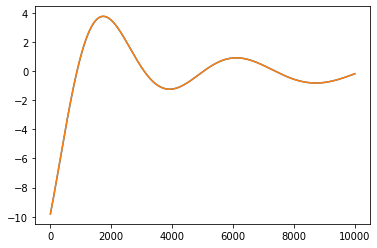

Epoch 25



Epoch 25 , mean error: 6.230882e-05 params: [DeviceArray([[2.000153]], dtype=float32), DeviceArray([[0.99651504]], dtype=float32)]


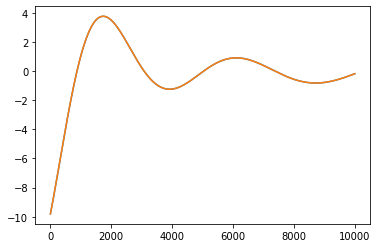

Epoch 26



Epoch 26 , mean error: 1.3145242e-05 params: [DeviceArray([[2.0000389]], dtype=float32), DeviceArray([[0.9985981]], dtype=float32)]


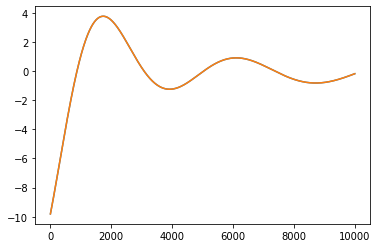

Epoch 27


KeyboardInterrupt: 

In [97]:
step_size = 1e-3
batch_size = 32
epochs = 100
init_fun, opt_update, get_params = adam(step_size=step_size)

params = initialize_params(rng, dims=1)
opt_state = init_fun(params)



def train_step(q, q_dot, q_dot2, f, opt_state, opt_update):
    params = get_params(opt_state)
    mse, grad = value_and_grad(loss)(params, q, q_dot, q_dot2, f)
    opt_state = opt_update(0, grad, opt_state)
    params = get_params(opt_state)
    return get_params(opt_state), opt_state, mse


#def train_epoch(batch_size, q, q_dot, q_dot2, f, opt_state, opt_update):

epoch_errors = []
for epoch in range(epochs):

    n_batchs = len(q)//batch_size
    errors = []
  
  
    print("Epoch", epoch)
    for i in tqdm(range(n_batchs)):
        q_batch      = jnp.array(q[i*batch_size:((i+1)*batch_size)])
        q_dot_batch  = jnp.array(q_dot[i*batch_size:((i+1)*batch_size)])
        q_dot2_batch = jnp.array(q_dot2[i*batch_size:((i+1)*batch_size)])
        f_batch = jnp.array(f[i*batch_size:((i+1)*batch_size)])
        params, opt_state, error = train_step(q_batch, q_dot_batch, q_dot2_batch, f_batch, opt_state, opt_update)
        errors.append(error)
  
    mean_error = np.mean(np.array(errors))
    print("Epoch", epoch, ", mean error:",mean_error, "params:", params)
    epoch_errors.append(mean_error)
    
    y_pred = np.array(batch_forward_pass(params, q, q_dot, f))
    plt.plot(np.squeeze(y_pred)[undo_shuffle])
    plt.plot(np.squeeze(q_dot2)[undo_shuffle])
    plt.show()
    
  

In [ ]:
def hess(params, q, q_dot):
    return jnp.linalg.pinv(jnp.squeeze(hessian(lag, argnums=1)(params, q, q_dot)).reshape(q_dot.shape[0], q_dot.shape[0]))
    
batch_hess = vmap(hess, in_axes=(None, 0, 0), out_axes=0)
batch_hess(params, q, q_dot)

In [13]:
params

[(DeviceArray([[-4.87105280e-01,  1.62394270e-02, -3.58996764e-02,
                -2.15390325e-01, -1.39771712e+00,  1.42531717e+00],
               [-4.19698954e-02,  7.25570738e-01, -5.21345794e-01,
                 1.01074135e+00, -1.30458224e+00, -2.51444459e-01],
               [ 6.01488315e-02, -6.21835947e-01,  9.24514160e-02,
                 3.49420726e-01,  9.81931463e-02, -5.32513261e-01],
               [ 1.05398941e+00, -8.08608592e-01, -1.96588945e+00,
                -1.74847043e+00,  1.27869236e+00, -1.38032353e+00],
               [ 3.88120681e-01,  1.54876983e+00, -8.90086815e-02,
                 2.15161264e-01,  4.89281952e-01,  1.40107656e+00],
               [ 1.84088063e+00,  1.36858836e-01,  1.53663456e-01,
                 6.97172821e-01, -1.32237756e+00,  8.14382613e-01],
               [-6.63943470e-01, -7.59218693e-01, -2.40540206e-01,
                -1.22755706e+00, -1.36399996e+00,  1.54113993e-01],
               [ 8.35359395e-01,  2.07824782e-01,  3.75